# IndiaMart PriceRangePrediction

New Section


```
# To Achieve the target, we have assumed the following things:

      1. 85% and above prices should be retained after outlier detection for finding the price range.
      2. Units which have counts < 5 are removed.
     
```


```
# The following ensemble technique is used to find outliers:

        1. Isolation Forests - IF
        2. DBScan
        3. LOF
        4. MaxVote(IF, DBScan, LOF)
```

```

# For estimation of amount of contamination, Inter-Quartile Range Data is considered. If Data(IQR)==100%, it is set to 98% and if <=85%, it is set to 87%
```

The **contamination**  factor and **epsilon** value are not fixed and infered dynamically by the above technique. Primary test indicate robust nature of this technique.


##Imports

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


##Data Preprocessing

In [0]:
#read data
data1 = pd.read_csv('t1.csv')
data2 = pd.read_csv('t2.csv')
data3 = pd.read_csv('t3.csv')

#remove empty columns
data1 = data1.drop(columns=['Unnamed: 3','Unnamed: 4'])
data2 = data2.drop(columns=['Unnamed: 3','Unnamed: 4'])
data3 = data3.drop(columns=['Unnamed: 3','Unnamed: 4'])

### Categories Consolidation

1. Merge similar **units** by stemming. For example, "KG" and "Kilogram" are merged. Similarily, "Unit" and "unit" are merged.

2. Remove **units** whole value < 5.

Processing : **Data 1**

In [76]:
data1.Unit.unique()

array(['Piece', 'Piece(s)', 'pack', 'unit', 'Number', 'Unit', 'Pack',
       '1nos', 'Unit(s)', 'kit', 'Set', 'Pc_Onwards', 'ONWARDS', 'Kit'],
      dtype=object)

In [77]:
data1_group = data1.groupby(by='Unit')
data1_group.describe()

Price                              ...                           
            count          mean           std  ...      50%      75%      max
Unit                                           ...                           
1nos          1.0   2100.000000           NaN  ...   2100.0   2100.0   2100.0
Kit           1.0   5690.000000           NaN  ...   5690.0   5690.0   5690.0
Number       14.0   7822.357143   8373.961415  ...   5385.0   6955.0  29840.0
ONWARDS       1.0   5000.000000           NaN  ...   5000.0   5000.0   5000.0
Pack          9.0   3303.888889   1668.343973  ...   3096.0   3399.0   7499.0
Pc_Onwards    5.0   8200.000000   2489.979920  ...  10000.0  10000.0  10000.0
Piece       119.0   4586.991597   5631.041341  ...   2500.0   4995.0  39830.0
Piece(s)      5.0   1615.800000    575.150589  ...   1600.0   2079.0   2300.0
Set           1.0   4895.000000           NaN  ...   4895.0   4895.0   4895.0
Unit         17.0  18025.647059  20295.580125  ...   8000.0  35000.0  55000.0
Unit(s)       1.0   2150.000000           NaN  ...   2150.0   2150.0   2150.0
kit           1.0   2243.000000           NaN  ...   2243.0   2243.0   2243.0
pack         47.0   8713.489362  11848.402409  ...   3179.0   7619.5  47462.0
unit         25.0   6024.040000   7682.493277  ...   2909.0   6230.0  37848.0

[14 rows x 8 columns]

In [78]:
data1.Unit = data1.Unit.replace({"Unit": "unit","Pack": "pack"})
data1_group = data1.groupby(by='Unit')
data1_group.describe()

Price                              ...                            
            count          mean           std  ...      50%       75%      max
Unit                                           ...                            
1nos          1.0   2100.000000           NaN  ...   2100.0   2100.00   2100.0
Kit           1.0   5690.000000           NaN  ...   5690.0   5690.00   5690.0
Number       14.0   7822.357143   8373.961415  ...   5385.0   6955.00  29840.0
ONWARDS       1.0   5000.000000           NaN  ...   5000.0   5000.00   5000.0
Pc_Onwards    5.0   8200.000000   2489.979920  ...  10000.0  10000.00  10000.0
Piece       119.0   4586.991597   5631.041341  ...   2500.0   4995.00  39830.0
Piece(s)      5.0   1615.800000    575.150589  ...   1600.0   2079.00   2300.0
Set           1.0   4895.000000           NaN  ...   4895.0   4895.00   4895.0
Unit(s)       1.0   2150.000000           NaN  ...   2150.0   2150.00   2150.0
kit           1.0   2243.000000           NaN  ...   2243.0   2243.00   2243.0
pack         56.0   7844.089286  11037.956356  ...   3179.0   6340.00  47462.0
unit         42.0  10881.833333  15193.547412  ...   4484.5   9790.75  55000.0

[12 rows x 8 columns]

In [0]:
#thresholding

data1 = data1[data1.Unit != 'Kit']
data1 = data1[data1.Unit != 'ONWARDS']
data1 = data1[data1.Unit != 'Set']
data1 = data1[data1.Unit != 'Unit(s)']
data1 = data1[data1.Unit != 'kit']
data1 = data1[data1.Unit != '1nos']

In [80]:
data1.head()

,Category Name,Unit,Price
0,Impact Drill,Piece,2
1,Impact Drill,Piece,675
2,Impact Drill,Piece,766
3,Impact Drill,Piece,900
4,Impact Drill,Piece,1000


Processing : **Data 2**

In [81]:
data2_group = data2.groupby(by='Unit')
data2_group.describe()

Price                            ...                         
              count         mean          std  ...     50%     75%      max
Unit                                           ...                         
Pack            3.0   766.333333   681.118443  ...   781.0  1110.5   1440.0
Pair          113.0   102.557522    68.740446  ...    80.0   170.0    350.0
Pair(s)         2.0   315.000000   190.918831  ...   315.0   382.5    450.0
Piece           6.0   136.666667   116.390148  ...    95.0   225.0    300.0
Pieces          1.0   695.000000          NaN  ...   695.0   695.0    695.0
Set             1.0   600.000000          NaN  ...   600.0   600.0    600.0
Unit            3.0   318.666667   405.000412  ...   100.0   443.0    786.0
Unit/Onwards    1.0   100.000000          NaN  ...   100.0   100.0    100.0
pack            5.0  4507.000000  8134.481114  ...  1150.0  2210.0  18974.0
unit            9.0  2442.777778  2764.160848  ...  1152.0  2594.0   8978.0

[10 rows x 8 columns]

In [0]:
data2.Unit = data2.Unit.replace({"Unit": "unit", "Pack": "pack"})
data2.Unit = data2.Unit.replace({"Unit": "unit","Pack": "pack"})

In [83]:
#Thresholding

data2 = data2[data2.Unit != 'Pair(s)']
data2 = data2[data2.Unit != 'Pieces']
data2 = data2[data2.Unit != 'Set']
data2 = data2[data2.Unit != 'Unit/Onwards']

data2_group = data2.groupby(by='Unit')
data2_group.describe()

Price                                                                 
       count         mean          std   min     25%    50%      75%      max
Unit                                                                         
Pair   113.0   102.557522    68.740446  10.0   50.00   80.0   170.00    350.0
Piece    6.0   136.666667   116.390148  40.0   40.00   95.0   225.00    300.0
pack     8.0  3104.250000  6456.924052  51.0  132.00  965.5  1632.50  18974.0
unit    12.0  1911.750000  2551.370225  70.0  680.25  974.0  1829.75   8978.0

Processing : **Data 3**

In [84]:
data3['Unit'] = data3['Unit'].str.lower()
data3_group = data3.groupby(by='Unit')
data3_group.describe()

Price                            ...                           
                   count         mean          std  ...     50%      75%       max
Unit                                                ...                           
1                   76.0   867.368421  1747.883443  ...   500.0   890.00   15000.0
1 pc                 1.0  1200.000000          NaN  ...  1200.0  1200.00    1200.0
1 pcs                1.0  1650.000000          NaN  ...  1650.0  1650.00    1650.0
1 pice               2.0   800.000000     0.000000  ...   800.0   800.00     800.0
1 piece              1.0   750.000000          NaN  ...   750.0   750.00     750.0
10                   2.0   999.000000     0.000000  ...   999.0   999.00     999.0
10-10000             1.0   399.000000          NaN  ...   399.0   399.00     399.0
100 pic              1.0   300.000000          NaN  ...   300.0   300.00     300.0
1000 per unit        1.0  1300.000000          NaN  ...  1300.0  1300.00    1300.0
12 units             2.0   450.000000     0.000000  ...   450.0   450.00     450.0
170 per peice        1.0   170.000000          NaN  ...   170.0   170.00     170.0
1pc                  3.0   446.666667   265.581124  ...   600.0   600.00     600.0
1pcd                 1.0  1400.000000          NaN  ...  1400.0  1400.00    1400.0
1pcs                 1.0  1200.000000          NaN  ...  1200.0  1200.00    1200.0
1piece               3.0  1096.666667  1063.265411  ...   750.0  1520.00    2290.0
1pis                 1.0   450.000000          NaN  ...   450.0   450.00     450.0
20' container        6.0  1165.666667  1186.141082  ...   847.5  1075.00    3500.0
3 set                1.0  1250.000000          NaN  ...  1250.0  1250.00    1250.0
4 pcs                1.0   575.000000          NaN  ...   575.0   575.00     575.0
4 units              1.0   575.000000          NaN  ...   575.0   575.00     575.0
40' container        5.0   996.000000  1464.997440  ...   320.0   430.00    3615.0
5                    2.0   617.500000    45.961941  ...   617.5   633.75     650.0
bag                 23.0  1107.913043  1037.577463  ...   725.0  1375.00    4792.0
barrel               2.0   215.000000    49.497475  ...   215.0   232.50     250.0
box                  9.0  1048.777778   779.117093  ...   900.0  1500.00    2350.0
carton               1.0   190.000000          NaN  ...   190.0   190.00     190.0
day                  2.0   575.000000   247.487373  ...   575.0   662.50     750.0
dollar               1.0     7.000000          NaN  ...     7.0     7.00       7.0
feet                 1.0  2000.000000          NaN  ...  2000.0  2000.00    2000.0
gram                 1.0  1600.000000          NaN  ...  1600.0  1600.00    1600.0
...                  ...          ...          ...  ...     ...      ...       ...
packet(s)            2.0   752.500000   357.088924  ...   752.5   878.75    1005.0
pair                17.0   787.588235   589.340421  ...   563.0   899.00    2200.0
pair piece           2.0   680.000000   282.842712  ...   680.0   780.00     880.0
pc                   1.0   550.000000          NaN  ...   550.0   550.00     550.0
pcs                  2.0   475.000000   176.776695  ...   475.0   537.50     600.0
peice                4.0   273.750000    87.118215  ...   247.5   287.50     400.0
per piece            2.0   399.500000   423.556962  ...   399.5   549.25     699.0
per piese            1.0   400.000000          NaN  ...   400.0   400.00     400.0
pi                   1.0   699.000000          NaN  ...   699.0   699.00     699.0
pices                2.0   672.500000   102.530483  ...   672.5   708.75     745.0
pics                 2.0   640.000000     0.000000  ...   640.0   640.00     640.0
piece             3372.0   798.738731  2314.038599  ...   500.0   799.00  109000.0
piece(s)           500.0   642.600000   490.081650  ...   500.0   900.00    4000.0
piece(s) onwards     1.0   350.000000          NaN  ...   350.0   350.00     350.0
pieces              15.0   471.9333

In [0]:
data3.Unit = data3.Unit.replace({"single piece": "piece",
                                 "per piece": "piece",
                                 "per piese":"piece",
                                 "pi":"piece",
                                 "peice":"piece",
                                 "pcs":"piece",
                                 "onepices":"piece",
                                 "one unit":"piece",
                                 "one pcs":"piece",
                                 "1":"piece",
                                 "1 pc":"piece",
                                 "1 pcs":"piece",
                                 "1 pice":"piece",
                                 "1 piece":"piece",
                                 "1pc":"piece",
                                 "1pcd":"piece",
                                 "1pcs":"piece",
                                 "1piece":"piece",
                                 "1pis":"piece",
                                 "single":"piece",
                                 "Unit":"unit",
                                 "Pc":"piece",
                                 "no":"number",
                                 "one":"piece",
                                 "one peace":"piece",
                                 "pair piece":"pair",
                                 "pc":"piece",
                                 "pics":"piece",
                                 "pices":"piece",
                                 "psc":"pieces",
                                 "unit(s)":"unit",
                                 "set(s)":"sets",
                                 "packet":"pack",
                                 "packet(s)":"pack",
                                 "packets":"pack",
                                 "piece(s)":"pieces",
                                 "piece(s) onwards":"pieces"
                                 })

data3 = data3[data3.Unit != '10']
data3 = data3[data3.Unit != '170 per peice']
data3 = data3[data3.Unit != '10-10000']
data3 = data3[data3.Unit != '100 pic']
data3 = data3[data3.Unit != '12 units']
data3 = data3[data3.Unit != '1000 per unit']
data3 = data3[data3.Unit != '3 set']
data3 = data3[data3.Unit != '4 pcs']
data3 = data3[data3.Unit != '4 units']
data3 = data3[data3.Unit != '5']
data3 = data3[data3.Unit != 'barrel']
data3 = data3[data3.Unit != 'carton']
data3 = data3[data3.Unit != 'day']
data3 = data3[data3.Unit != 'feet']
data3 = data3[data3.Unit != 'pound']
data3 = data3[data3.Unit != 'year']
data3 = data3[data3.Unit != 'unstitch']
data3 = data3[data3.Unit != 'xl size']
data3 = data3[data3.Unit != 'rs']
data3 = data3[data3.Unit != 'suit']
data3 = data3[data3.Unit != 'selfie kurtis']
data3 = data3[data3.Unit != 'dollar']
data3 = data3[data3.Unit != 'gram']
data3 = data3[data3.Unit != 'in']
data3 = data3[data3.Unit != 'kilogram']
data3 = data3[data3.Unit != 'meter']
data3 = data3[data3.Unit != 'ounce']
data3 = data3[data3.Unit != 'ounce(s)']

In [86]:
data3_group = data3.groupby(by='Unit')
data3_group.describe()

Price                            ...                         
                count         mean          std  ...    50%     75%       max
Unit                                             ...                         
20' container     6.0  1165.666667  1186.141082  ...  847.5  1075.0    3500.0
40' container     5.0   996.000000  1464.997440  ...  320.0   430.0    3615.0
bag              23.0  1107.913043  1037.577463  ...  725.0  1375.0    4792.0
box               9.0  1048.777778   779.117093  ...  900.0  1500.0    2350.0
kurti             5.0   573.400000   121.824874  ...  599.0   599.0     700.0
number           60.0   870.366667   592.397512  ...  726.5  1000.0    3800.0
onwards          48.0   518.229167   106.608698  ...  500.0   500.0     850.0
pack             21.0   858.047619   998.798852  ...  500.0  1000.0    3700.0
pair             19.0   776.263158   560.647824  ...  563.0   889.5    2200.0
piece          3488.0   798.933486  2290.240236  ...  500.0   799.0  109000.0
pieces          519.0   642.059730   488.471300  ...  500.0   900.0    4000.0
set              44.0  1653.840909  6545.811847  ...  577.5   810.0   44000.0
sets              7.0   862.857143   736.115124  ...  500.0  1075.0    2290.0
unit             74.0  1247.135135  4091.978395  ...  500.0   790.5   35050.0

[14 rows x 8 columns]

In [87]:
#concat all data
data = pd.concat([data1,data2,data3])
data.groupby(['Category Name','Unit']).describe()

Price                ...                    
                                      count          mean  ...       75%       max
Category Name         Unit                                 ...                    
Impact Drill          Number           14.0   7822.357143  ...   6955.00   29840.0
                      Pc_Onwards        5.0   8200.000000  ...  10000.00   10000.0
                      Piece           119.0   4586.991597  ...   4995.00   39830.0
                      Piece(s)          5.0   1615.800000  ...   2079.00    2300.0
                      pack             56.0   7844.089286  ...   6340.00   47462.0
                      unit             42.0  10881.833333  ...   9790.75   55000.0
Ladies Kurta          20' container     6.0   1165.666667  ...   1075.00    3500.0
                      40' container     5.0    996.000000  ...    430.00    3615.0
                      bag              23.0   1107.913043  ...   1375.00    4792.0
                      box               9.0   1048.777778  ...   1500.00    2350.0
                      kurti             5.0    573.400000  ...    599.00     700.0
                      number           60.0    870.366667  ...   1000.00    3800.0
                      onwards          48.0    518.229167  ...    500.00     850.0
                      pack             21.0    858.047619  ...   1000.00    3700.0
                      pair             19.0    776.263158  ...    889.50    2200.0
                      piece          3488.0    798.933486  ...    799.00  109000.0
                      pieces          519.0    642.059730  ...    900.00    4000.0
                      set              44.0   1653.840909  ...    810.00   44000.0
                      sets              7.0    862.857143  ...   1075.00    2290.0
                      unit             74.0   1247.135135  ...    790.50   35050.0
Leather Safety Gloves Pair            113.0    102.557522  ...    170.00     350.0
                      Piece             6.0    136.666667  ...    225.00     300.0
                      pack              8.0   3104.250000  ...   1632.50   18974.0
                      unit             12.0   1911.750000  ...   1829.75    8978.0

[24 rows x 8 columns]

# Driver Program

**The Main Ensembled Function**

In [0]:
def findPriceRange(datas,contamination_factor,seed_percentage):
    
    
    datax = datas
    datay = datas
    dataz = datas
    ######_____Isolation Forests
    
    isolation_forest = IsolationForest(contamination=contamination_factor)
    if_vote = isolation_forest.fit_predict(dataz['Price'].values.reshape(-1,1))
    
    ######_____DBScan
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import DBSCAN
     
    scaler = MinMaxScaler()
    sd = scaler.fit_transform(datax)
    sd = pd.DataFrame(sd,columns=['Price'])
    
    
    outlier_detection = DBSCAN(eps = getHyperparameters(sd,seed_percentage) ,metric="euclidean",min_samples = 3,n_jobs = -1)
    clusters = outlier_detection.fit_predict(sd)
    clusters[clusters!=-1]=1
    
    dbscan_vote = clusters
    
    ######_____Local Outlier Factor
    clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination_factor)
    y_pred = clf.fit_predict(np.array(datay['Price']).reshape(-1,1))
    X_scores = clf.negative_outlier_factor_

    lof_vote = y_pred
    

    
    final_votes = lof_vote + if_vote + dbscan_vote
    final_votes[final_votes>0] = 1
    final_votes[final_votes<0]=0
    pure_data = final_votes*np.array(datas['Price'])
    pure_data = np.extract(pure_data!=0, pure_data)
    min_price, max_price = np.min(pure_data), np.max(pure_data)
    return([min_price, max_price, pure_data])
    

In [0]:

def plot_figure(x,c,u,min_price,max_price):
    
    k = x
    fig, ax = plt.subplots()
    num_bins = 10
    n, bins, patches = ax.hist(k['Price'], num_bins, color=['grey'])
    d = ax.fill_betweenx(n,min_price,max_price,color='g',alpha=0.5)
    ax.set_xlabel('Prices')
    ax.set_ylabel('Counts')
    ax.set_title(r'Histogram for item-'+ c +' and unit - '+ u)
    fig.tight_layout()
    plt.show()

def getHyperparameters(sd,retain):
  
  import math
  
  dis=[]
  temp =list(sd['Price'])
  for i in range(0,len(temp)-1):
    dis.append(temp[i+1]-temp[i])

  arr = np.array(dis)
  diss = pd.DataFrame(dis,columns=['dis'])
  std=diss['dis'].std()
  ma = diss['dis'].max()
  n=len(dis)
  
  cnt={}
  unique_dis=list(set(dis))
  for i in unique_dis:
    cnt[i]=dis.count(i)
  keys = cnt.keys()
  keys=sorted(keys)
  cands=[]
  full = int(round((retain*n),0))
  for i in keys:
    full = full - cnt[i]
    cands.append(i)
    if(full<=0):
      break
    
  
  b = pd.DataFrame(cands)
  epsilon = round(np.max(np.array(b))*1000,0)/1000
  return(epsilon)
  

In [0]:
def estimateContamination(dataChunk):
  
  #index column addition
  unnormal_data=pd.DataFrame(dataChunk)

  # Computing IQR
  Q1 = unnormal_data['Price'].quantile(0.25)
  Q3 = unnormal_data['Price'].quantile(0.75)
  IQR = Q3 - Q1 

  import random
  label_data = list(unnormal_data['Price'])
  t=[]
  for i in range(len(unnormal_data['Price'])):
    if( (label_data[i] <= (Q1 - 1.5 * IQR)) or (label_data[i] >= (Q3 + 1.5 * IQR))):
      t.append(-1)
    else:
      t.append(1)

  filtered = t
  #keep seed percentage == IQR range or 85% or 98%
  #assume 85%-98% purityz
  import math

  seed_percentage  = math.floor((len(filtered)/len(unnormal_data))*100)
  if(seed_percentage<85):
    seed_percentage = 87
  elif(seed_percentage>=99):
    seed_percentage = 98

#   print("Seed Percentage :",seed_percentage)

  contamination_factor=0.5*((100-seed_percentage)/100)    
  
  return([seed_percentage, contamination_factor])

In [0]:
#function to retrive relevant prices
#usage example : accessData('Impact Drill','Piece')

def accessData(category,unit):
  return(data['Price'][(data['Category Name']==category) & (data['Unit'] == unit)])

In [0]:
#dictionary catgory  -> unit -> prices

indexes = {}
categories = list(set(list(data['Category Name'])))
for category in categories:
  units = list(set(list(data['Unit'][data['Category Name'] == category])))
  indexes[category]=units

In [93]:
data.head()

,Category Name,Unit,Price
0,Impact Drill,Piece,2
1,Impact Drill,Piece,675
2,Impact Drill,Piece,766
3,Impact Drill,Piece,900
4,Impact Drill,Piece,1000


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


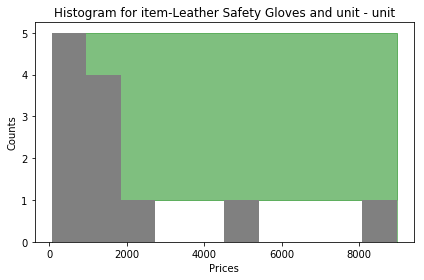

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


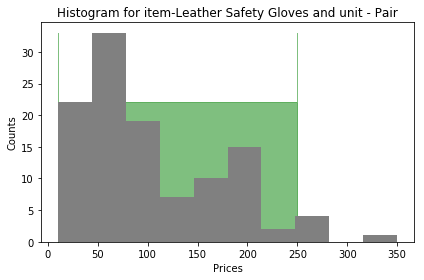

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


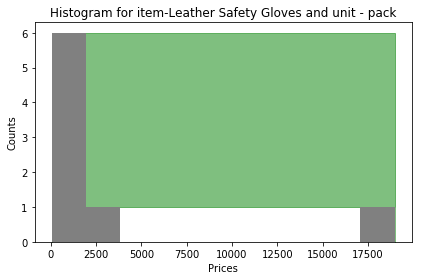

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


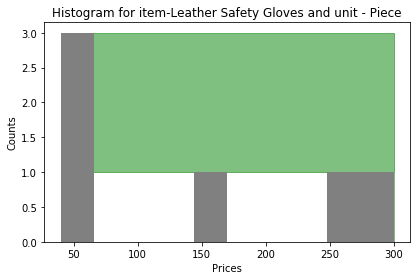

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


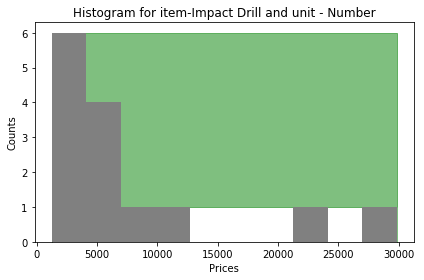

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


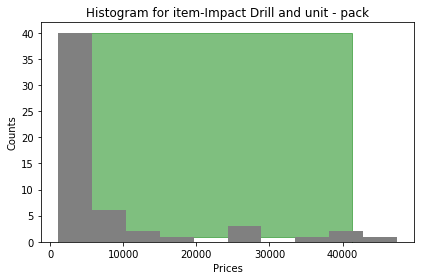

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


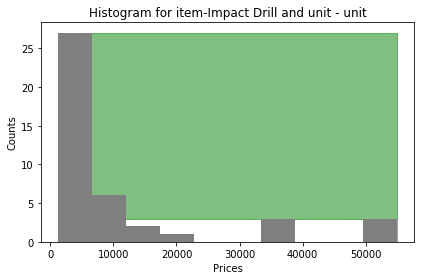

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


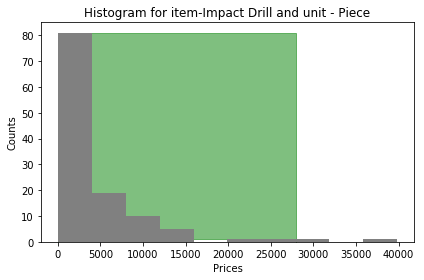

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


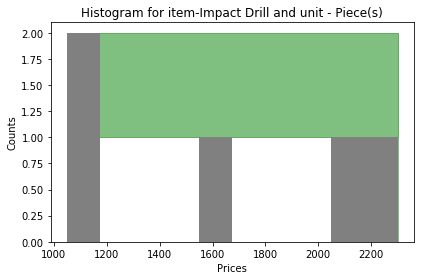

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


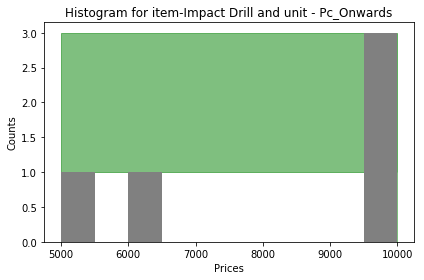

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


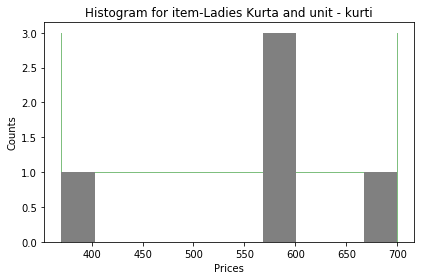

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


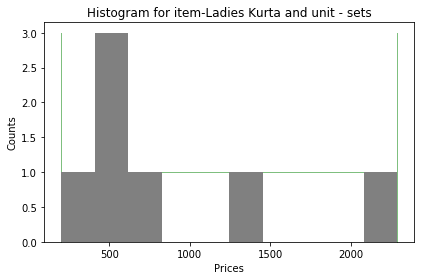

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


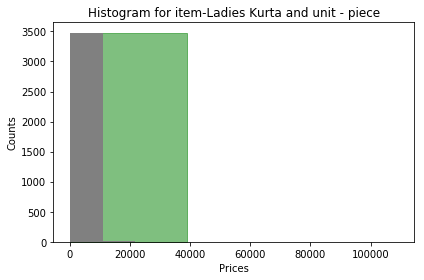

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


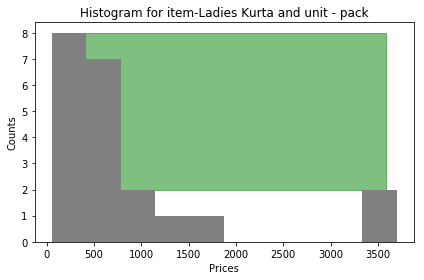

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


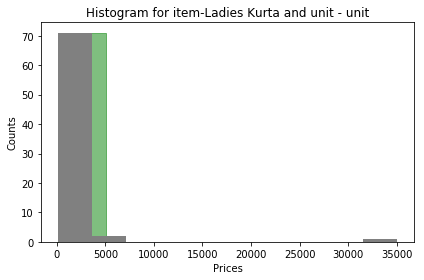

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


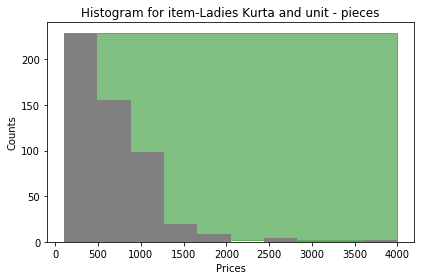

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


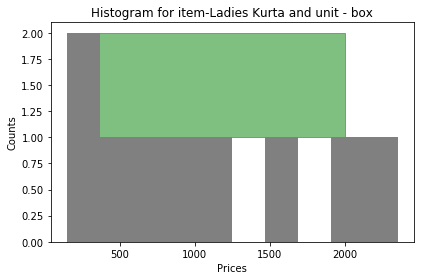

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


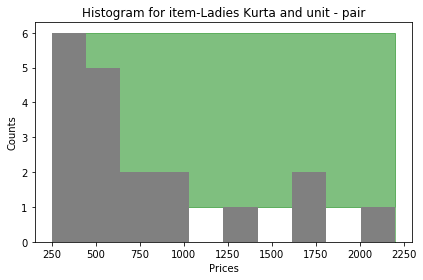

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


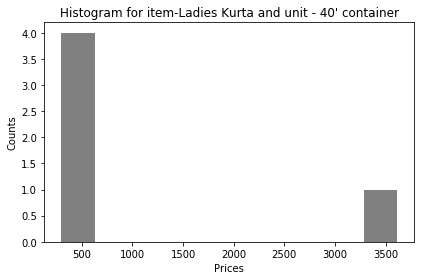

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


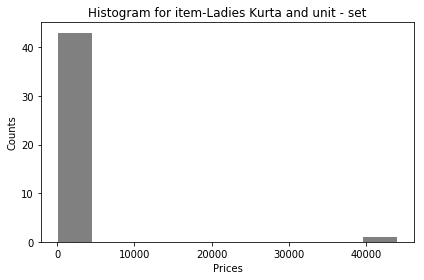

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


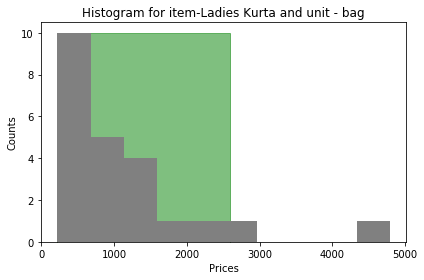

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


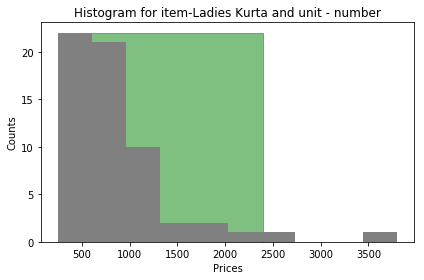

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


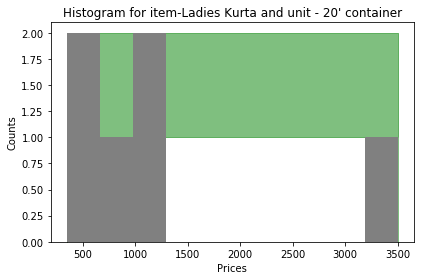

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


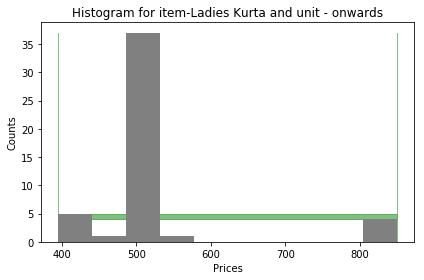

In [94]:
debug = 0
prints=[]

for category in categories:
  for j in range(len(indexes[category])):
    
    dataChunk = pd.DataFrame(accessData(category,indexes[category][j]))
    minn, maxx, pdata = findPriceRange(dataChunk,estimateContamination(dataChunk)[1], estimateContamination(dataChunk)[0])
    prints.append("Price Range for {} per {} is {} to {}".format(category, indexes[category][j], minn, maxx))
    plot_figure(dataChunk,category,indexes[category][j],minn,maxx)


### Results Visualisation

In [0]:

def plot_figure(x,c,u,min_price,max_price):
    
    k = x
    fig, ax = plt.subplots()
    num_bins = 10
    n, bins, patches = ax.hist(k['Price'], num_bins, color=['grey'])
    d = ax.fill_betweenx(n,min_price,max_price,color='g',alpha=0.5)
    ax.set_xlabel('Prices')
    ax.set_ylabel('Counts')
    ax.set_title(r'Histogram for item-'+ c +' and unit - '+ u)
    fig.tight_layout()
    plt.show()

# Individual Algorithm Analysis Section

## Isolation Forests

The challenge is to determine contamination factor

NameError: ignored

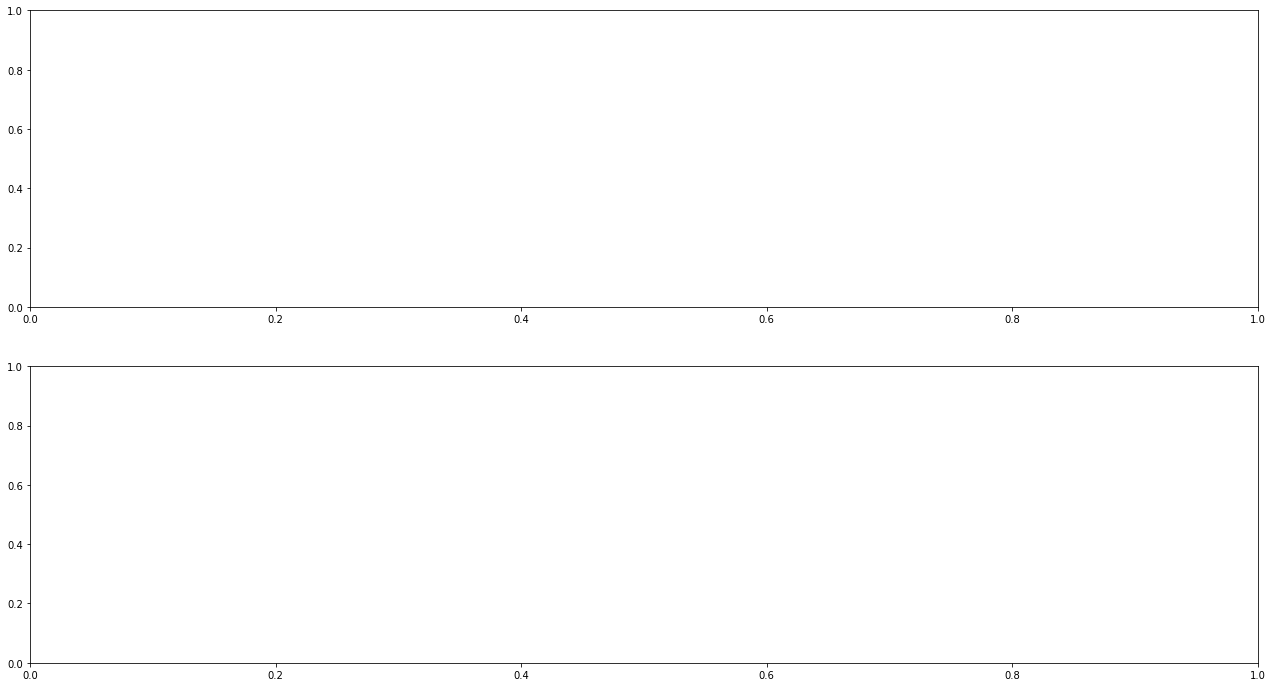

In [0]:
df = data
fig, axs = plt.subplots(2, 1, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination=contamination_factor)
    z = isolation_forest.fit_predict(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    
    
    anomaly_score = isolation_forest.decision_function(df[column].values.reshape(-1,1))
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)
    


In [0]:
if_vote = z

NameError: ignored

In [0]:
z

NameError: ignored

## DBScan

The challenge is to set *e* value.

In [0]:
def getHyperparameters(sd,retain):
  
  import math
  
  dis=[]
  temp =list(sd['Price'])
  for i in range(0,len(temp)-1):
    dis.append(temp[i+1]-temp[i])

  arr = np.array(dis)
  diss = pd.DataFrame(dis,columns=['dis'])
  std=diss['dis'].std()
  ma = diss['dis'].max()
  n=len(dis)
  
  cnt={}
  unique_dis=list(set(dis))
  for i in unique_dis:
    cnt[i]=dis.count(i)
  keys = cnt.keys()
  keys=sorted(keys)
  cands=[]
  full = int(round((retain*n),0))
  for i in keys:
    full = full - cnt[i]
    cands.append(i)
    if(full<=0):
      break
    
  
  b = pd.DataFrame(cands)
  epsilon = round(np.max(np.array(b))*1000,0)/1000
  return(epsilon)
  



  

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sd = scaler.fit_transform(data)
sd = pd.DataFrame(sd,columns=['Price'])


ValueError: ignored

In [0]:
import math
dis=[]
temp =list(sd['Price'])
for i in range(0,len(temp)-1):
  dis.append(temp[i+1]-temp[i])

arr = np.array(dis)

diss = pd.DataFrame(dis,columns=['dis'])
diss.describe()
std=diss['dis'].std()
ma = diss['dis'].max()
n=len(dis)

In [0]:
cnt={}
unique_dis=list(set(dis))
for i in unique_dis:
  cnt[i]=dis.count(i)
keys = cnt.keys()
keys=sorted(keys)


print(len(keys))

  

In [0]:
cands=[]
full = int(round((0.92*n),0))
for i in keys:
  full = full - cnt[i]
  cands.append(i)
  if(full<=0):
    break
    


In [0]:

b = pd.DataFrame(cands)
b.describe()
epsilon = round(np.max(np.array(b))*1000,0)/1000
epsilon

In [0]:
#main

from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
  eps = epsilon ,
  metric="euclidean",
  min_samples = 3,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(sd)

NameError: ignored

In [0]:
cluster_map = pd.DataFrame()
cluster_map['cluster'] = outlier_detection.labels_
cluster_map[cluster_map.cluster == 0]
clusters[clusters!=-1]=1
dbscan_vote = clusters

In [0]:
dbscan_vote

## LOF

In [0]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination_factor)
y_pred = clf.fit_predict(data)
X_scores = clf.negative_outlier_factor_

lof_vote = y_pred

NameError: ignored

In [0]:
lof_vote

## Autoencoders (To Be Used Later)


To be used later, when more data is available. This would be a semi-supervised learning approach, where <=5% of total data should be labeled. This will greatly improve the accurcy of price range prediction.

In [0]:
#prepare 5-10% labeled data

data=[]
for i in indices:
  data.append(label_data[i])
  
data = np.array(data)
  
  
indices=[]
limit = int(round(0.4*len(t),0))
while(1):
  i = random.randint(0,len(t))
  if(limit<=0):
    break
  if(t[i]!=-1):
    indices.append(i)
    limit = limit - 1
  

NameError: ignored

In [0]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

In [0]:
data =  data.reshape(-1,48)
data

AttributeError: ignored

In [0]:
from sklearn.model_selection import data_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [0]:
input_size = 48

encoding_dim = 24
hidden_dim = int(encoding_dim / 2) 
learning_rate = 1e-7

input_layer = Input(shape=(input_size,))

decoder = Dense(hidden_dim, activation='relu')(input_layer)
decoder = Dense(input_size, activation='linear')(decoder)

autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics = ['mean_squared_error'])
autoencoder.summary()

In [0]:
autoencoder.fit(data, data, epochs=300)


NameError: ignored

In [0]:
reconstructed = autoencoder.predict(data)
reconstructed

NameError: ignored

In [0]:
markers = []
checks = list(data - reconstructed)
checks = checks[0]


for i in range(len(checks)):
  if(abs(checks[i])>2):
    markers.append(-1)
  else:
    markers.append(1)

np.array(markers)